# Web Scraping for Indeed.com and Predicting Salaries

In this project, I collected data by scraping the website Indeed.com and then built a binary predictor to determine if the anticipated salary is above a particular threshold.

I collected salary information on data science jobs in a variety of markets and, using the location, title and summary of the job I attempted to predict the salary of the job. 

While most listings DO NOT come with salary information, being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, I would use regression for this task; however, by converting this problem into a classification problem allowed me to try out classification algorithms and also set a minimum threshold for salary. Also, there is a fair amount of natural variance in job salaries so predicting a range may be more useful.

## Executive summary
___

**Problem**: 

Indeed.co.uk has lots of jobs listed but only a small number of listings have a salary associated with the specific job. How can we estimate the salary range for a job with no salary listed?

**Solution**:

A predictive model which takes the job title, location and company as inputs and returns whether the salary is likely to be a high salary (above the median of all related salaries) or a low salary (below the median).

**Considerations**:

Incorrectly predicting a high salary for a job can cause significantly more real world problems than predicting a lower salary for a job. For example, an individual is likely to have a minimum salary requirement but less likely to have a maximum salary requirement.

Therefore, the model is currently adjusted so that it only predicts a high salary when it calculates a probability of more than 70% that the salary will be high based on the inputs provided. This is so that the model is being more cautious when predicting high salaries. This threshold can be adjusted if necessary.

**Results**:

***Output***

Our test data contained 186 job listings. Of these, 93 were high salary jobs and 93 were low salary jobs.

The model correctly predicted 33 out of 93 jobs with high salaries. However, the model also predicted 10 low salary jobs as high salary jobs. The remaining jobs were all predicted as low salary jobs:


||predicted high salary|predicted low salary|
|---|---|---|
|actual high salary|33|60|
|actual low salary|10|83|


Whilst the model did incorrectly classify 70 of the jobs, this was in a large part due to the 70% threshold required prior to predicting a high salary job (as 60/70 errors were predicting low salary jobs for jobs which were actually high salary jobs).

***Factors influencing high salary jobs***

The model is also able to determine those factors that influence high or low salary jobs. For high salary jobs the most influential factors include:
- Jobs in London or Hampshire
- Job titles including 'lead', 'head', 'principal' or 'senior'
- Specific companies, like Capita IT Resourcing

For low salary jobs, the most influential factors include:
- Job titles including 'analyst' or 'graduate'
- Jobs in Newcastle upon Tyne
- Jobs at Universities

Whilst this is not too surprising, it gives confidence that the model has identified the items that genuinely influence salary and therefore gives confidence that the model is reliable. In addition, it is possible to view the weighting that the model applies to each factor. There is a reasonable spread across a number of different factors which gives further confidence that the model is providing a reasonable prediction.

**Approach**:

***Step 1: Web scraping and data cleaning***

Data on job titles, locations, companies and salaries (where available) was scraped from the indeed.co.uk website. This data was then filtered to only include job titles that include the terms ***data***, ***machine learning*** and ***statistician***. 

In addition, basic data cleaning was performed to remove those jobs with no salary listed, standardise the location information (i.e. set London, South Kensington and East London all equal to London) and remove salary information from job titles (e.g. Data Scientist £55,000 becomes Data Scientist). 

***Step 2: Model development***

The data was split into a training set (used during the machine learning element of model development) and a test set (to assess the quality of the machine learning).

The training data was then used to train a number of different models and optimise each model's parameters.

***Step 3: Model testing***

The best models were then selected and tested using the test data to ensure the quality of the models. As the best model passed this testing stage, this was identified as the final model.

The values listed above are the values predicted by the final model on the test data.

___

## Scraping job listings from Indeed.com

I scraped job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where I could easily find relevant entries.

In [333]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import multiprocessing as mp
import threading
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import scikitplot as skplt


%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Multi-threading salary range - UK website

In [15]:
def extract_job_title_mt(result):
    """
    Extracts the job title for a job on Indeed's website
    """
    try:
        job_title = result.find('a', attrs={'class':'turnstileLink'}).text
    except:
        job_title = np.nan
    return job_title

def extract_company_mt(result):
    """
    Extracts the company for a job on Indeed's website
    """
    try:
        company = result.find('span', attrs={'class':'company'}).text
    except:
        company = np.nan
    return company

def extract_location_mt(result):
    """
    Extracts the location for a job on Indeed's website
    """
    try:
        location = result.find('span', attrs={'class':'location'}).text
    except:
        try:
            location = result.find('div', attrs={'class':'location'}).text
        except:
            location = np.nan
    return location

def extract_salary_mt(result):
    """
    Extracts the salary for a job on Indeed's website
    """
    try:
        salary = result.find('span', attrs={'class':'no-wrap'}).text
    except:
        salary = np.nan
    return salary

def jobs_df_from_html(dict_html):
    """
    Creates a dataframe from the html for each job on the indeed website
    
    Dataframe includes:
    - Job title
    - Company
    - Location
    - Salary
    """
    job_title = []
    company = []
    location = []
    salary = []
    for value in dict_html.values():
        soup = BeautifulSoup(value, 'html.parser')
        for job in soup.find_all('div', attrs={'class': re.compile('jobsearch-SerpJobCard.*')}):
            job_title.append(extract_job_title_mt(job))
            company.append(extract_company_mt(job))
            location.append(extract_location_mt(job))
            salary.append(extract_salary_mt(job))

    jobs = pd.DataFrame({'Job_title': job_title,
                           'Company': company,
                         'Location': location,
                        'Salary': salary})
    return jobs

def request_html(url_template,term,sal_rng,return_dict):
    """
    Obtains html from indeed.co.uk for a specific city
    """
    # Find max number of pages
    pg_url = url_template.format(term,sal_rng,0)
    req = requests.get(pg_url)
    soup = BeautifulSoup(req.text, 'html.parser')
    job_count = str(soup.find('div', attrs = {'id':'searchCount'}))
    job_count = int(job_count.split(' ')[-2].replace(',',''))
    if job_count > 1500:
        job_count = 1500
    max_sal_rng_results = int(np.ceil(job_count/1.5))
    
    for start in tqdm_notebook(range(0, max_sal_rng_results, 10)):
        url = url_template.format(term,sal_rng,start)
        try:
            r = requests.get(url)
        except requests.RequestException:
            return None
        if r.status_code != 404:
            key = sal_rng+'_'+str(start)
            return_dict[key] = r.text

def request_concurrent(sal_rng_list,search_terms):
    """
    Multithreading for requesting html from indeed.co.uk
    
    html obtained using function request_html
    
    Threaded by city
    """
    manager = mp.Manager()
    return_dict = manager.dict()
    threads = []
    
    url_template = "https://www.indeed.co.uk/jobs?as_and={}&salary={}&start={}"
    
    for term in tqdm_notebook(search_terms):
        for sal_rng in tqdm_notebook(sal_rng_list):
            thread = threading.Thread(name=term+'_'+sal_rng, target=request_html,
                                      args=(url_template,term,sal_rng,return_dict))
            thread.start()
            threads.append(thread)
    
    for t in threads:
        t.join()
    
    return return_dict

Using multi-threading by salary range

In [139]:
sal_rng_list = ['£0K-£20K','£25K-£30K','£30K-£35K','£35K-£37K','£37K-£40K','£40K-£42K','£42K-£45K','£45K-£47K',\
                '£47K-£50K','£50K-£52K','£52K-£55K','£55K-£57K','£57K-£60K','£60K-£62K','£62K-£65K','£65K-£70K',\
                '£70K-£75K','£75K-£80K','£80K-£100K','£100K+']

search_terms = ['data+science']

dict_html = request_concurrent(sal_rng_list,search_terms)

mt_scraped_jobs = jobs_df_from_html(dict_html)

In [140]:
mt_scraped_jobs.shape

(12133, 4)

### Cleaning data received

In [141]:
def clean_jobs(jobs_df):
    """
    Cleans a pandas dataframe received from scraping the indeed.co.uk website
    """
    # Remove blank salaries
    an_sal_jobs = jobs_df.dropna().copy()

    # Mask for annual salaries
    sal_yr_mask = [an_sal_jobs['Salary'].iloc[i][-4:]=='year' for i,val in enumerate(an_sal_jobs['Salary'])]
    # Selecting only annual salaries
    an_sal_jobs = an_sal_jobs[sal_yr_mask]

    # Mask for sterling
    sterling_mask = ['£' in i for i in an_sal_jobs['Salary']]
    # Select only sterling salaries
    an_sal_jobs = an_sal_jobs[sterling_mask]

    # Remove duplicates
    an_sal_jobs.drop_duplicates(inplace=True)
    
    # Remove carriage returns
    for i in an_sal_jobs.columns:
        an_sal_jobs[i] = an_sal_jobs[i].map(lambda x: x.replace('\n',''))
        
    output = an_sal_jobs
    return output

In [142]:
def salary_str_to_number(series_salary_str):
    """
    Converts a pandas series of strings from the UK indeed website to a list of numbers
    
    Extracts the values from the string and averages 
    """
    salary_range = series_salary_str.map(lambda x: x.replace('a year','').\
                                             replace('\n','').replace('£','').replace(',',''))

    salary_range = salary_range.map(lambda x: x.split('-'))

    output = [float(i[0]) if len(i) == 1 else (int(i[0])+int(i[1]))/2 for i in salary_range]

    return output

In [143]:
an_sal_jobs = clean_jobs(mt_scraped_jobs)
an_sal_jobs['Average_salary'] = salary_str_to_number(an_sal_jobs['Salary'])

In [144]:
an_sal_jobs.shape

(2097, 5)

In [145]:
an_sal_jobs.head()

,Job_title,Company,Location,Salary,Average_salary
0,Junior Data Analyst,Stericycle,Exeter,"£18,000 - £20,000 a year",19000.0
1,Data Administrator,Williams Lea Tag,Newport NP10,"£15,821 a year",15821.0
2,Product Listing E-commerce Assistant/Data Entry,BargainShopUK,London,"£18,700 - £20,000 a year",19350.0
3,Registration of Interest (Talent Pool) - 2019 ...,UK Power Networks,East London,"£15,000 a year",15000.0
4,13 Month Placement - Data Science (July 2019),BMW (UK) Manufacturing Ltd.,United Kingdom,"£17,500 a year",17500.0


### Save results as a CSV

In [146]:
an_sal_jobs.to_csv('UK_DS_jobs.csv',index=False)

## Predicting salaries - machine learning

#### Load in the the data of scraped salaries

In [3]:
path_DS = './UK_DS_jobs.csv'

salaries_df = pd.read_csv(path_DS)

# Remove duplicates
salaries_df.drop_duplicates(inplace=True)

In [5]:
salaries_df.shape

(3032, 5)

In [6]:
salaries_df.head()

,Job_title,Company,Location,Salary,Average_salary
0,Junior Data Analyst,Stericycle,Exeter,"£18,000 - £20,000 a year",19000.0
1,Data Administrator,Williams Lea Tag,Newport NP10,"£15,821 a year",15821.0
2,Product Listing E-commerce Assistant/Data Entry,BargainShopUK,London,"£18,700 - £20,000 a year",19350.0
3,Registration of Interest (Talent Pool) - 2019 ...,UK Power Networks,East London,"£15,000 a year",15000.0
4,13 Month Placement - Data Science (July 2019),BMW (UK) Manufacturing Ltd.,United Kingdom,"£17,500 a year",17500.0


### Exploratory Data Analysis

In [7]:
eda_df = salaries_df.copy()

In [8]:
eda_df['Job_title'].value_counts()

Data Scientist                                                     117
Data Engineer                                                       43
Senior Data Scientist                                               35
Data Analyst                                                        21
Software Engineer                                                   21
Product Manager                                                     18
Lead Data Scientist                                                 18
Software Developer                                                  15
Machine Learning Engineer                                           15
Senior Software Engineer                                            13
Python Developer                                                    13
Research Fellow                                                     12
Senior Data Engineer                                                11
DevOps Engineer                                                      8
Web De

Clearly there are some non-data science job titles (e.g. Software engineer, Java developer, DevOps Engineer, KTP Associate, Front end developer etc).

These will need to be removed from the data to make it data science specific.

In [9]:
eda_df['Location'].value_counts()

London                          1282
Cambridge                        101
Oxford                            96
United Kingdom                    63
Birmingham                        52
Manchester                        50
Southampton                       35
Glasgow                           30
Uxbridge                          28
Leeds                             27
Bristol                           27
Greater London                    25
Nottingham                        25
Reading                           23
South Kensington                  22
Newcastle upon Tyne               19
Edinburgh                         19
Didcot                            18
Liverpool                         17
Sheffield                         16
South West London                 16
Cambridgeshire                    16
East London                       16
Milton Keynes                     15
Hertfordshire                     14
Exeter                            14
Swindon                           13
S

There are a number of locations that include the start of the postcode. These will need to be amended to only include the location (to match the other entries).

There are also a number of London locations that are not listed as London. E.g.:

- East London
- West London
- Bank Station
- South Kensington
- Canary Wharf

These should be amended to be just London

#### Update main data set to only include items identified in eda

Filter job titles

In [10]:
salaries_df = salaries_df[[True if 'Data' in i else \
        True if 'DATA' in i else \
        True if 'data' in i else \
        True if 'Machine Learning' in i else \
        True if 'Machine learning' in i else \
        True if 'machine learning' in i else \
        True if 'Statistician' in i else \
        True if 'statistician' in i else \
        False for i in salaries_df['Job_title']]]

Update locations

In [14]:
salaries_df['Location'] = [' '.join(i.split(' ')[:-1]) if any(char.isdigit() for char in i) else i \
                           for i in salaries_df['Location']]
    

salaries_df['Location'] = salaries_df['Location'].map(lambda x: 'London' if 'London' in x else x)

london_loc_list = ['Canary Wharf','Camden','Old Street','West End','Marylebone','Southwark',\
                   'Bank Station','South Kensington','Richmond upon Thames']

salaries_df['Location'] = ['London' if i in london_loc_list else i for i in salaries_df['Location']]

#### I want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

I could also perform Linear Regression (or any regression) to predict the salary value here. Instead, I am going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. I didn't have to choose the `median` as the splitting point - I could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [15]:
salary_threshold = salaries_df['Average_salary'].median()

salaries_df['High_salary'] = [1 if i>salary_threshold else 0 for i in salaries_df['Average_salary']]

In [16]:
salary_threshold

57500.0

In [17]:
salaries_df.head()

,Job_title,Company,Location,Salary,Average_salary,High_salary
0,Junior Data Analyst,Stericycle,Exeter,"£18,000 - £20,000 a year",19000.0,0
1,Data Administrator,Williams Lea Tag,Newport,"£15,821 a year",15821.0,0
2,Product Listing E-commerce Assistant/Data Entry,BargainShopUK,London,"£18,700 - £20,000 a year",19350.0,0
4,13 Month Placement - Data Science (July 2019),BMW (UK) Manufacturing Ltd.,United Kingdom,"£17,500 a year",17500.0,0
5,Data Science Summer Internship,Capital One - UK,Nottingham,"£18,000 a year",18000.0,0


#### Baseline accuracy for this model

The baseline accuracy is slightly higher than 0.5 as I have selected the median to split the calssification, with values on the median being allocated to the 0 class.

In [18]:
baseline = (salaries_df['High_salary'].value_counts()/len(salaries_df['High_salary']))[0]

In [19]:
baseline

0.5016181229773463

### Part I: location only


#### Model based on location:

- Started by ONLY using the location as a feature. 

#### EDA

In [20]:
eda_df = salaries_df.copy()

In [21]:
eda_df.sort_values('Average_salary',ascending=False,inplace=True)

In [22]:
eda_df[['Location','High_salary']].groupby('Location').count()

,High_salary
Location,
Aberdeen,1
Aberdeenshire,1
Abingdon,1
Andover,1
Bath,2
Bedfordshire,2
Belfast,11
Berkshire,5
Birmingham,3


In [23]:
df_plot = eda_df.groupby(['High_salary', 'Location']).size().reset_index().pivot(columns='High_salary', index='Location', values=0)

In [24]:
df_plot.reset_index(inplace=True)

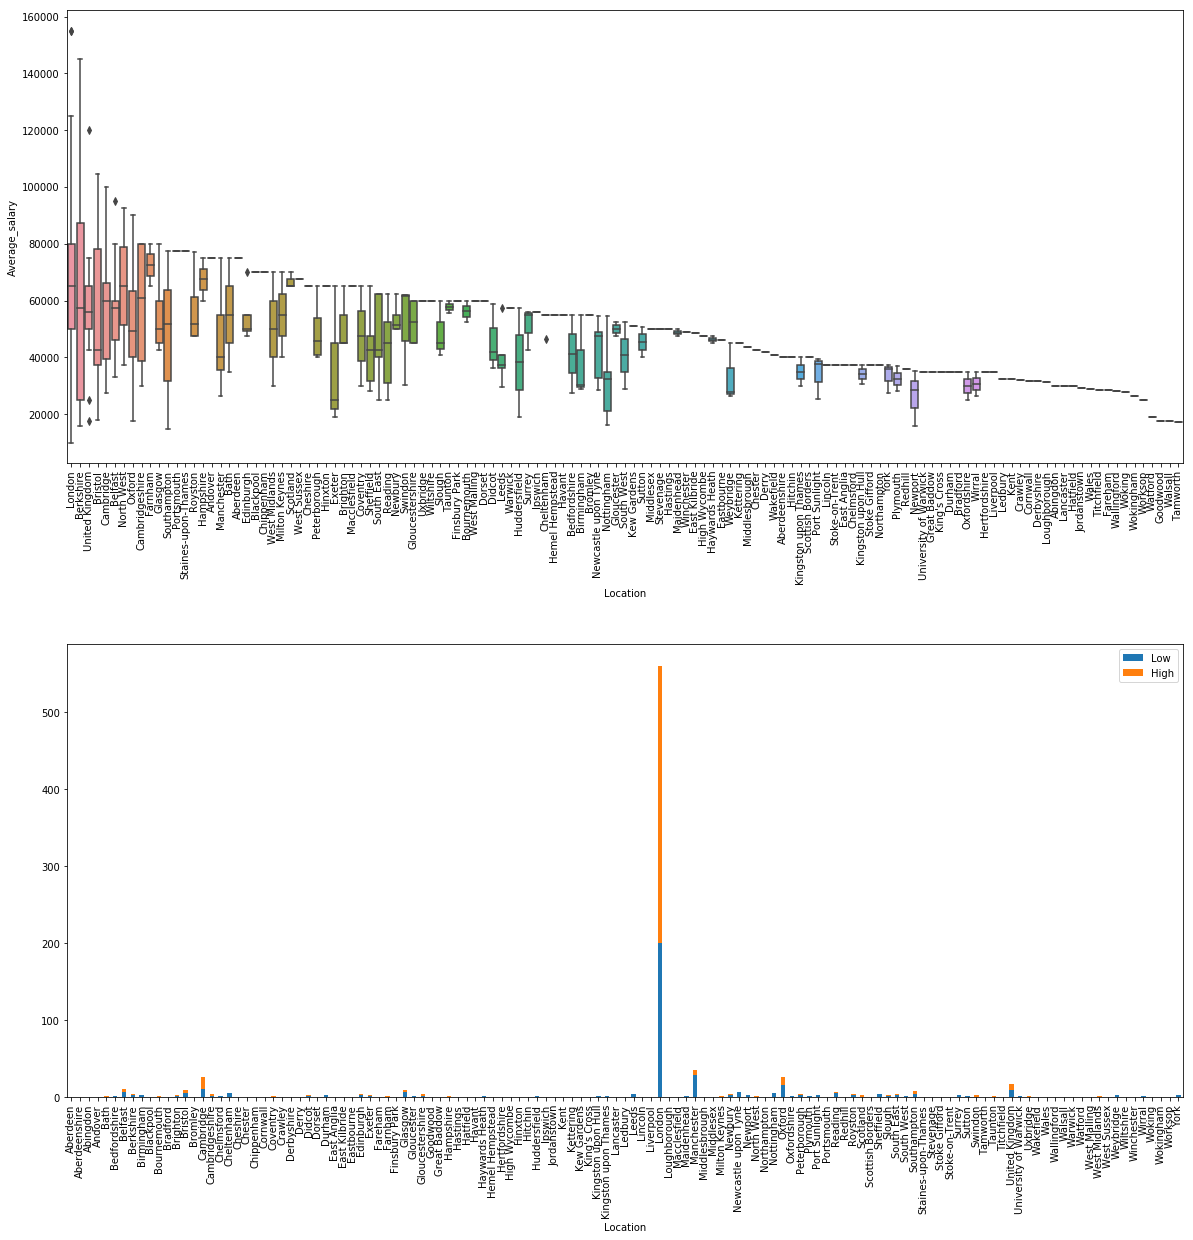

In [25]:
fig, ax = plt.subplots(2,1,figsize=(20,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

sns.boxplot(x=eda_df['Location'], y=eda_df['Average_salary'],ax=ax[0])
df_plot.plot(x='Location', kind='bar', stacked=True, ax=ax[1])

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
plt.xticks(rotation=90)
#plt.yscale('log')
plt.legend( ('Low', 'High'))

plt.show()

#### Analysis

The large majority of UK Data Science jobs are based in London. In addition, the jobs seems to be split about 1/3 : 2/3 low to high salary so a model only using location will be OK as if a job is in London then it should be high and for most other locations it should be low.

#### Outliers

I will keep all data in the dataset as the thing we are predicting is the number above or below the median, and the median is not likely to be skewed particularly far by a small number of large outliers

### Dummify location

In [369]:
X = salaries_df['Location']
y = salaries_df['High_salary']

In [370]:
X_dum = pd.get_dummies(X,drop_first=True)

### Train test split

In [371]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=1,\
                                                    shuffle=True, stratify=y)

### Training baseline

In [29]:
train_baseline = y_train.value_counts()[0]/len(y_train)
train_baseline

0.5020242914979757

### sklearn Logistic Regression

In [30]:
sk_log_reg = LogisticRegression(solver='lbfgs')
sk_log_reg.fit(X_train,y_train)
print('Accuracy: ',sk_log_reg.score(X_test,y_test))

Accuracy:  0.6290322580645161


This is a reasonable score as it is higher than the baseline and the location data is not a clear predictor of high vs low salary.

In [31]:
y_pred_sk_log = sk_log_reg.predict(X_test)

conmat = np.array(confusion_matrix(y_test, y_pred_sk_log, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,71,22
low_salary,47,46


### statsmodels Logistic Regression

In [52]:
X_train_sm = X_train.copy()
X_train_sm = X_train_sm.values
X_train_sm = sm.add_constant(X_train_sm)

sm_log_reg = sm.Logit(y_train,X_train_sm)
# sm_result = sm_log_reg.fit(method = 'lbfgs',maxiter=35)
sm_result = sm_log_reg.fit(method = 'cg',maxiter=1000)
sm_result.summary()

Optimization terminated successfully.
         Current function value: 0.526319
         Iterations: 347
         Function evaluations: 1134
         Gradient evaluations: 1134


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            High_salary   No. Observations:                  741
Model:                          Logit   Df Residuals:                      624
Method:                           MLE   Df Model:                          116
Date:                Sat, 24 Nov 2018   Pseudo R-squ.:                  0.2407
Time:                        09:01:59   Log-Likelihood:                -390.00
converged:                       True   LL-Null:                       -513.62
                                        LLR p-value:                 1.654e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7209        nan        nan        nan         nan         nan
x1                  0        nan        nan        nan         nan         nan
x2            -7.8318        nan        nan        nan         nan         nan
x3             8.6863        nan        nan        nan         nan         nan
x4            -1.7208        nan        nan        nan         nan         nan
x5            -7.8318        nan        nan        nan         nan         nan
x6            -2.8200        nan        nan        nan         nan         nan
x7            -2.1244        nan        nan        nan         nan         nan
x8            -8.5076        nan        nan        nan         nan         nan
x9             8.6863        nan        nan        nan         nan         nan
x10           -1.7208        nan        nan        nan         nan         nan
x11           -7.8318        nan        nan        nan         nan         nan
x12           -2.4127        nan        nan        nan         nan         nan
x13           -2.4155        nan        nan        nan         nan         nan
x14           -7.8318        nan        nan        nan         nan         nan
x15           -1.6345        nan        nan        nan         nan         nan
x16           -2.4127        nan        nan        nan         nan         nan
x17           -8.5076        nan        nan        nan         nan         nan
x18           -9.2145        nan        nan        nan         nan         nan
x19            8.6863        nan        nan        nan         nan         nan
x20           -7.8318        nan        nan        nan         nan         nan
x21            8.6863        nan        nan        nan         nan         nan
x22           -7.8318        nan        nan        nan         nan         nan
x23           -1.7208        nan        nan        nan         nan         nan
x24                 0        nan        nan        nan         nan         nan
x25           -7.8318        nan        nan        nan         nan         nan
x26           -7.8318        nan        nan        nan         nan         nan
x27           -2.4127        nan        nan        nan         nan         nan
x28            8.6863        nan        nan        nan         nan         nan
x29           -8.5076        nan        nan        nan         nan         nan
x30           -7.8318        nan        nan        nan         nan         nan
x31           -7.8318        nan        nan        nan         nan         nan
x32           -7.8318        nan        nan        nan         nan         nan
x33           -2.8197        nan        nan        nan         nan         nan
x34           -2.4127        nan        nan        nan         nan         nan
x35                 0        nan        nan        nan         nan         nan
x36            9.4413        nan        nan        nan         nan         nan
x37            8.6863        nan        nan        nan         nan         nan
x3

### Feature importance

In [53]:
log_reg_coefs = pd.DataFrame(sk_log_reg.coef_.T,index=X_train.columns,columns=['sklearn_coefs'])
log_reg_coefs['stat_mod_coefs'] = sm_result.params[1:].values

In [54]:
log_reg_coefs.sort_values('sklearn_coefs',inplace=True,ascending=False)

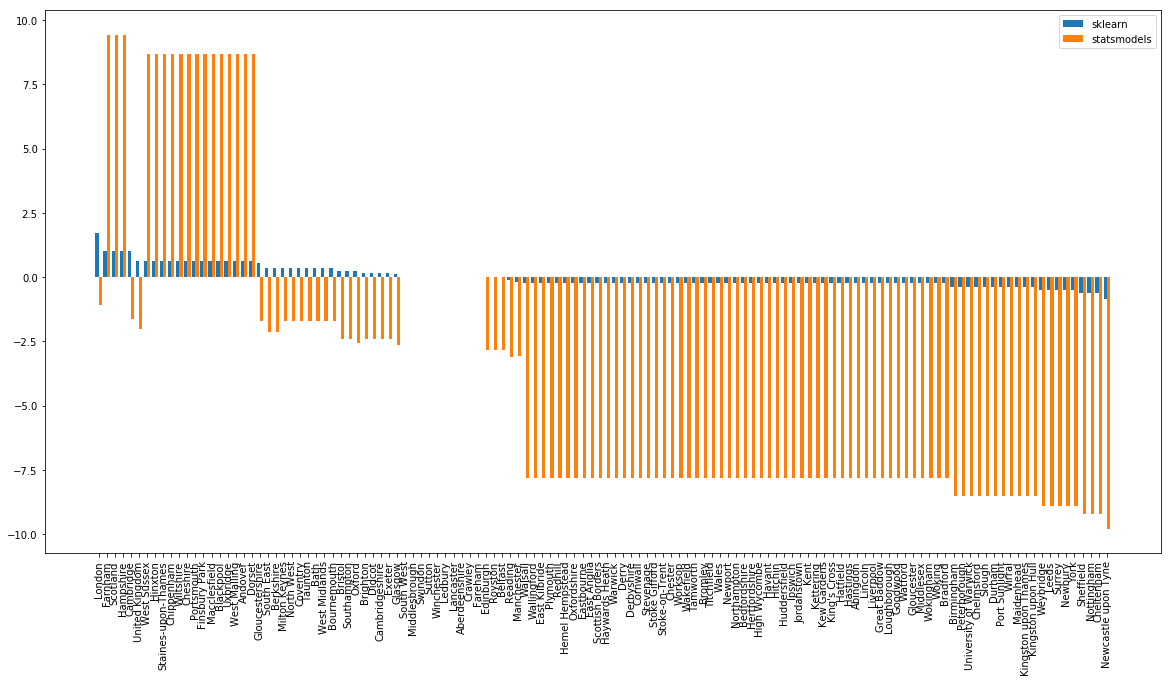

In [55]:
nd = np.arange(len(log_reg_coefs.index))
width = 0.4

fig, ax = plt.subplots(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax.bar(x=nd,height=log_reg_coefs['sklearn_coefs'],width=width,label='sklearn')
ax.bar(x=nd+width,height=log_reg_coefs['stat_mod_coefs'],width=width,label='statsmodels')

plt.xticks(rotation=90)
ax.set_xticks(nd + width / 2)
ax.set_xticklabels(log_reg_coefs.index)
ax.legend()

plt.show()

### Explanation of coefficients

The larger the coefficient the more likely it is that a particular location has a higher proportion of higher paying jobs.

The statsmodel does not use regularisation and, as such, the resulting coefficients are starting to get quite extreme. As such, I would not trust the coefficients from the statsmodel Logistic Regression.

The more extreme values from the statsmodel Logistic Regression may arise due to a number of locations that only have a single job attached to them. This affect could potentially be reduced if these locations are removed (but the sklearn model avoids this by using regularisation).

### Additional classifier - KNN

In [297]:
knn_model = KNeighborsClassifier(n_neighbors=6)
knn_model.fit(X_train,y_train)
knn_model.score(X_test,y_test)

0.5752688172043011

### Part II: job levels and categories


#### Model taking into account job levels and categories:


In [56]:
eda_df = salaries_df.copy()

In [58]:
eda_df['Job_title'].value_counts()

Data Scientist                                                     117
Data Engineer                                                       43
Senior Data Scientist                                               35
Data Analyst                                                        21
Lead Data Scientist                                                 18
Machine Learning Engineer                                           15
Senior Data Engineer                                                11
Data Science Manager                                                 7
Data Science Consultant                                              5
Data Architect                                                       5
Senior Machine Learning Engineer                                     4
Data Analytics Manager                                               4
Big Data Engineer                                                    4
Senior Data Analyst                                                  4
Robert

There are a number of salaries included in the job description. These need to be removed.

In [128]:
eda_df['Company'].value_counts()

        Harnham                                               187
        Datatech Analytics                                     31
        Cathcart Associates                                    22
        Venturi                                                20
        Client Server                                          14
        Aspire Data Recruitment                                14
        University of Oxford                                   11
        Nigel Frank International Limited                      11
        Opus Recruitment Solutions                             11
        Mcgregor Boyall                                        11
        Lawrence Harvey                                        10
        Linux Recruit                                          10
        Understanding Recruitment                               8
        Reqiva                                                  8
        kdr Recruitment                                         7
        Ac

### Removing salaries from job titles

In [375]:
job_title = []
for i in eda_df['Job_title']:
    for j in i.split(' '):
        if any(char.isdigit() for char in j):
            i = i.replace(j,'')
        elif j in ['Bonus','Benefits','GBP','salary','Salary','generous']:
            i = i.replace(j,'')
        else:
            i=i
    job_title.append(i)
job_title

salaries_df['Job_title'] = job_title

### tf-idf vectorising job titles

In [376]:
tvec = TfidfVectorizer(strip_accents='ascii',analyzer='word',stop_words='english',min_df=0.01,max_df=0.7)

tvec.fit(salaries_df['Job_title'])

tvec_df = pd.DataFrame(tvec.transform(salaries_df['Job_title']).todense(),
                  columns=tvec.get_feature_names(),
                  index=salaries_df.index)

### Dummify location and company

In [377]:
loc_dum_df = pd.get_dummies(salaries_df['Location'],drop_first=True)

comp_dum_df = pd.get_dummies(salaries_df['Company'],drop_first=True)

### Create X and y

In [378]:
X = pd.concat([tvec_df,loc_dum_df,comp_dum_df],axis=1)
y = salaries_df['High_salary']

### Train test split

In [379]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

### Training baseline

In [380]:
train_baseline = y_train.value_counts()[0]/len(y_train)
train_baseline

0.5020242914979757

### sklearn Logistic Regression

In [146]:
sk_log_reg = LogisticRegression(solver='lbfgs')
sk_log_reg.fit(X_train,y_train)
print('Accuracy: ',sk_log_reg.score(X_test,y_test))

Accuracy:  0.6989247311827957


This is a reasonable score as it is higher than the previous model based purely on location data.

In [143]:
y_pred_sk_log = sk_log_reg.predict(X_test)

conmat = np.array(confusion_matrix(y_test, y_pred_sk_log, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,68,25
low_salary,31,62


### Gridsearch

### Logistic regression - L1

In [151]:
gs_params = {
    'C':np.logspace(-4,4,50),
    'penalty':['l1'],
    'solver':['liblinear', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 100 candidates, totalling 700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 395 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   36.6s


Best parameters:  {'C': 1.7575106248547894, 'penalty': 'l1', 'solver': 'liblinear'}
Cross val score:  0.7678543538734486


[Parallel(n_jobs=-1)]: Done 700 out of 700 | elapsed:  1.0min finished


#### Logistic regression - L1 - Narrowed range for C (1)

In [153]:
gs_params = {
    'C':np.logspace(-2,2,100),
    'penalty':['l1'],
    'solver':['liblinear', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 200 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done 1066 tasks      | elapsed:  1.2min


Best parameters:  {'C': 2.2051307399030455, 'penalty': 'l1', 'solver': 'liblinear'}
Cross val score:  0.7705238611050133


[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  2.1min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Logistic regression - L1 - Narrowed range for C (2)

In [157]:
gs_params = {
    'C':np.linspace(1,4,100),
    'penalty':['l1'],
    'solver':['liblinear', 'saga']
}

model = LogisticRegression(max_iter=1000)

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 200 candidates, totalling 1400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 299 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 549 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 899 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1349 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1400 out of 1400 | elapsed:  5.3min finished


Best parameters:  {'C': 1.9090909090909092, 'penalty': 'l1', 'solver': 'saga'}
Cross val score:  0.7705241010175892


### Logistic regression - L2

In [160]:
gs_params = {
    'C':np.logspace(-4,4,50),
    'penalty':['l2'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 250 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1314 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 1664 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:  1.9min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'C': 5.428675439323859, 'penalty': 'l2', 'solver': 'newton-cg'}
Cross val score:  0.7744906955905269


#### Logistic regression - L2 - Narrowed range for C (1)

In [154]:
gs_params = {
    'C':np.logspace(-2,2,100),
    'penalty':['l2'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 500 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 2655 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3105 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.1min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'C': 4.229242874389499, 'penalty': 'l2', 'solver': 'newton-cg'}
Cross val score:  0.7744524295346776


#### Logistic regression - L2 - Narrowed range for C (2)

In [159]:
gs_params = {
    'C':np.linspace(2,6,100),
    'penalty':['l2'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1521 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2421 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3493 out of 3500 | elapsed:  3.4min remaining:    0.4s


Best parameters:  {'C': 3.090909090909091, 'penalty': 'l2', 'solver': 'liblinear'}
Cross val score:  0.7744650249449101


[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.5min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The highest cross validated score for Logistic Regression is found for 'C': 5.428675439323859, 'penalty': 'l2', 'solver': 'newton-cg'.

The grid searched parameters for the Logistic Regression are pretty stable and are consistently giving a similar cross validated score, therefore it is likely to be valid.

### Random forest

Find initial range for number of trees

In [ ]:
list_all = []

for i in range(10,1000,50):
    print(i)
    list_i = []
    gs_params = {
        'n_estimators':[i]
        , 'criterion':['gini','entropy']
        , 'class_weight':[None,'balanced','balanced_subsample']
    }

    model = RandomForestClassifier()

    gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=0)

    gs_model.fit(X_train,y_train)

    gs_best_model = gs_model.best_estimator_

    scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)
    
    list_i.append(i)
    list_i.append(gs_model.best_params_)
    list_i.append(scores.mean())
    list_all.append(list_i)
list_all
#     print(i)
#     print('Best parameters: ',gs_model.best_params_)
#     print('Cross val score: ',scores.mean())

400
410
420
430
440
450
460
470
480


Narrow range for number of trees

In [182]:
list_all = []

for i in range(400,550,10):
    print(i)
    list_i = []
    gs_params = {
        'n_estimators':[i]
        , 'criterion':['gini','entropy']
        , 'class_weight':[None,'balanced','balanced_subsample']
    }

    model = RandomForestClassifier()

    gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=0)

    gs_model.fit(X_train,y_train)

    gs_best_model = gs_model.best_estimator_

    scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)
    
    list_i.append(i)
    list_i.append(gs_model.best_params_)
    list_i.append(scores.mean())
    list_all.append(list_i)
list_all
#     print(i)
#     print('Best parameters: ',gs_model.best_params_)
#     print('Cross val score: ',scores.mean())

400
410
420
430
440
450
460
470
480
490
500
510
520
530
540


[[400,
  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 400},
  0.7489987848428032],
 [410,
  {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 410},
  0.7489987848428032],
 [420,
  {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 420},
  0.7489350880539132],
 [430,
  {'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 430},
  0.7462779363200049],
 [440,
  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 440},
  0.7476128098920752],
 [450,
  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 450},
  0.7435440125618225],
 [460,
  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 460},
  0.7503593290604903],
 [470,
  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 470},
  0.7556993031739234],
 [480,
  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 480},
  0.7503082276818327],
 [490,
  {'class_weight': 'balanced_subsample',
   'criterion': 'entropy'

In [196]:
rndm_forest_scores = pd.DataFrame(list_all,columns=['n_estimators','params','accuracy'])

The best number of trees is 470 with 'class_weight': None, 'criterion': 'gini', 'n_estimators': 470

In [201]:
rndm_forest_scores.sort_values('accuracy',ascending=False).iloc[[0]]

,n_estimators,params,accuracy
7,470,"{'class_weight': None, 'criterion': 'gini', 'n...",0.755699


### Gradient boost

In [204]:
gs_params = {
    'loss':['deviance','exponential'],
    'n_estimators':range(10,1000,100),
    'criterion':['friedman_mse'], #'mse','mae',
    'max_depth':range(1,10,1)
}

model = GradientBoostingClassifier(random_state=1)

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 180 candidates, totalling 1260 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 1260 out of 1260 | elapsed: 26.5min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 1, 'n_estimators': 810}
Cross val score:  0.7623484802138101


### Ada boost

In [192]:
base_estimator = DecisionTreeClassifier()

gs_params = {
    'n_estimators':range(10,100,1),
    'base_estimator__max_depth':range(1,5,1)
}

model = AdaBoostClassifier(base_estimator=base_estimator, random_state=1)

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 360 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:  5.1min finished


Best parameters:  {'base_estimator__max_depth': 1, 'n_estimators': 23}
Cross val score:  0.7544264470027123


### KNN

In [206]:
gs_params = {
    'n_neighbors':range(1,20,1),
    'weights':['uniform','distance'],
    'p':[1,2,3]
}

model = KNeighborsClassifier()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1)

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7)

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 114 candidates, totalling 798 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 798 out of 798 | elapsed:  6.0min finished


Best parameters:  {'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Cross val score:  0.7233528502213794


### Discussion of model

#### Logistic Regression

The two models that perform the best are both Logistic Regression models with slightly different parameters:

Parameters: {'C': 3.090909090909091, 'penalty': 'l2', 'solver': 'liblinear'}

Parameters: {'C': 5.428675439323859, 'penalty': 'l2', 'solver': 'newton-cg'}

In [209]:
model_1 = LogisticRegression(C=3.090909090909091, penalty='l2', solver='liblinear')
model_1.fit(X_train,y_train)
y_pred_1 = model_1.predict(X_test)
              
conmat = np.array(confusion_matrix(y_test, y_pred_1, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,71,22
low_salary,30,63


In [210]:
model_2 = LogisticRegression(C=5.428675439323859, penalty='l2', solver='newton-cg')
model_2.fit(X_train,y_train)
y_pred_2 = model_2.predict(X_test)
              
conmat = np.array(confusion_matrix(y_test, y_pred_2, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,71,22
low_salary,30,63


Both models perform identically on the test data.

In [227]:
final_log_reg_coefs = pd.DataFrame(model_1.coef_.T,columns=['model_1_coefs'],index=X_train.columns)
final_log_reg_coefs['model_2_coefs'] = model_2.coef_.T

final_log_reg_coefs['model_1_coefs_abs'] = abs(final_log_reg_coefs['model_1_coefs'])
final_log_reg_coefs['model_2_coefs_abs'] = abs(final_log_reg_coefs['model_2_coefs'])

final_log_reg_coefs.sort_values('model_1_coefs_abs',ascending=False,inplace=True)

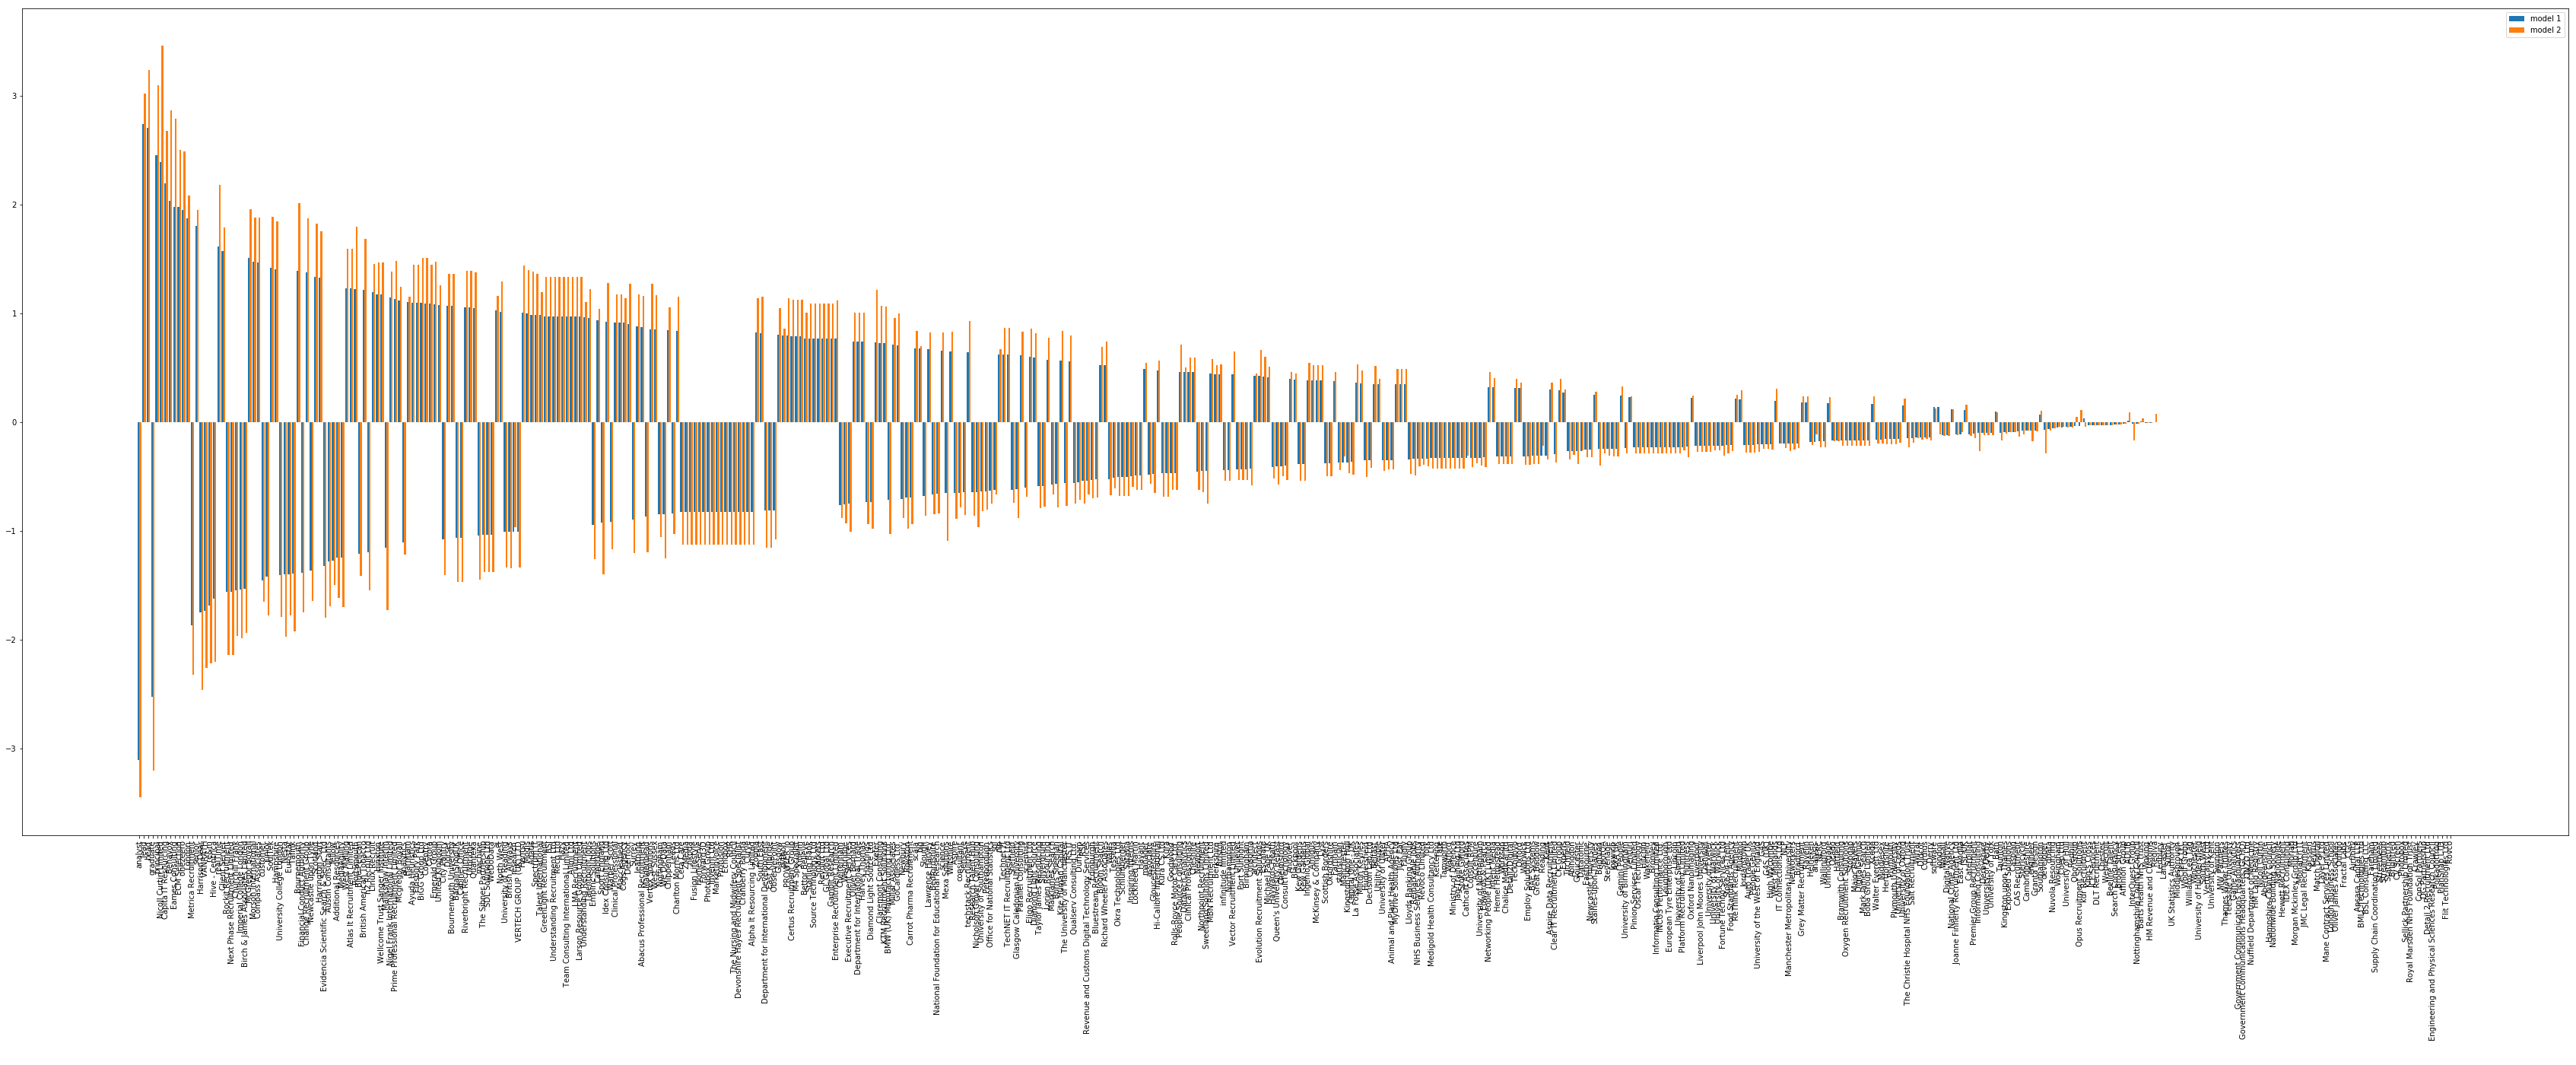

In [266]:
nd = np.arange(len(final_log_reg_coefs.index))
width = 0.4

fig, ax = plt.subplots(figsize=(60,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax.bar(x=nd,height=final_log_reg_coefs['model_1_coefs'],width=width,label='model 1')
ax.bar(x=nd+width,height=final_log_reg_coefs['model_2_coefs'],width=width,label='model 2')

plt.xticks(rotation=90)
ax.set_xticks(nd + width / 2)
ax.set_xticklabels(final_log_reg_coefs.index)
ax.legend()

plt.show()

All the coefficients are generally in agreement between the two models. Model two provides slightly higher absolute values for most coefficients.

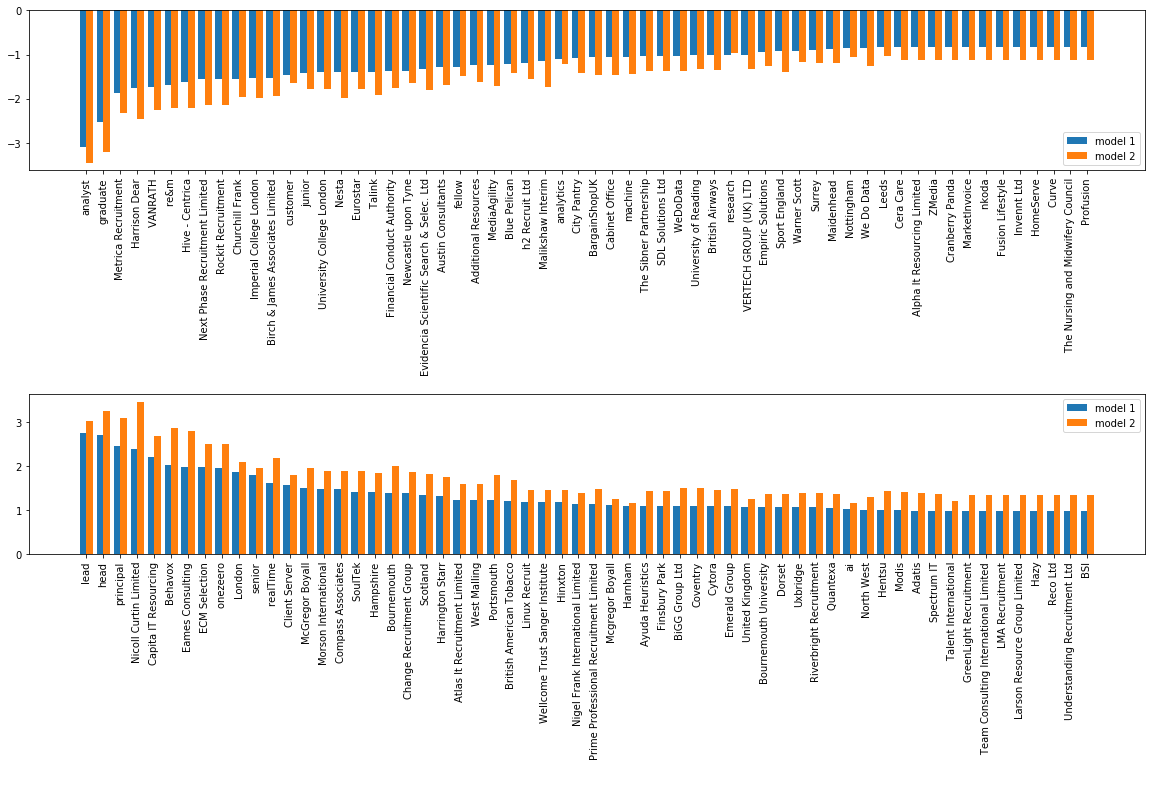

In [257]:
low_log_reg_coefs = final_log_reg_coefs.sort_values('model_1_coefs').iloc[:60]
hi_log_reg_coefs = final_log_reg_coefs.sort_values('model_1_coefs',ascending=False).iloc[:60]

nd = np.arange(len(low_log_reg_coefs.index))
width = 0.4

fig, ax = plt.subplots(2,1,figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.4)

ax[0].bar(x=nd,height=low_log_reg_coefs['model_1_coefs'],width=width,label='model 1')
ax[0].bar(x=nd+width,height=low_log_reg_coefs['model_2_coefs'],width=width,label='model 2')

ax[1].bar(x=nd,height=hi_log_reg_coefs['model_1_coefs'],width=width,label='model 1')
ax[1].bar(x=nd+width,height=hi_log_reg_coefs['model_2_coefs'],width=width,label='model 2')

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=90)
ax[0].set_xticks(nd + width / 2)
ax[0].set_xticklabels(low_log_reg_coefs.index)
ax[0].legend()

plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=90)
ax[1].set_xticks(nd + width / 2)
ax[1].set_xticklabels(hi_log_reg_coefs.index)
ax[1].legend()

plt.show()

As you would expect, there is a mixture of locations, key words from the job descriptions and employers that contribute to both higher and lower salaries.

For job descriptions with 'analyst', 'graduate' or 'junior' in them are indicators of lower salary jobs, whereas 'lead', 'head' and 'senior' are indicators of higher salaries.

For locations, London and Hampshire are indicators of higher salary jobs whereas Newcastle upon Tyne is an indicator of lower salary jobs.

For employers, universities tend to indicate lower salaries whereas recruitment firms like onezeero indicate higher salaries.

All these factors make sense when taken in context and are as expected.

#### Gradient Boost

The next best performing model is the Gradient Boost with the following parameters: {'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 1, 'n_estimators': 810}

In [211]:
model_t = GradientBoostingClassifier(criterion='friedman_mse',loss='exponential',max_depth=1,\
                                     n_estimators=810,random_state=1)
model_t.fit(X_train,y_train)
y_pred_t = model_t.predict(X_test)
              
conmat = np.array(confusion_matrix(y_test, y_pred_t, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,75,18
low_salary,34,59


This model predicts more higher paying jobs than the Logistic Regression models.

In [279]:
gb_feat_imp = pd.DataFrame(model_t.feature_importances_.T,columns=['gb_feat_imp'],index=X_train.columns)

gb_feat_imp.sort_values('gb_feat_imp',ascending=False,inplace=True)

gb_feat_imp_top = gb_feat_imp.iloc[:40]

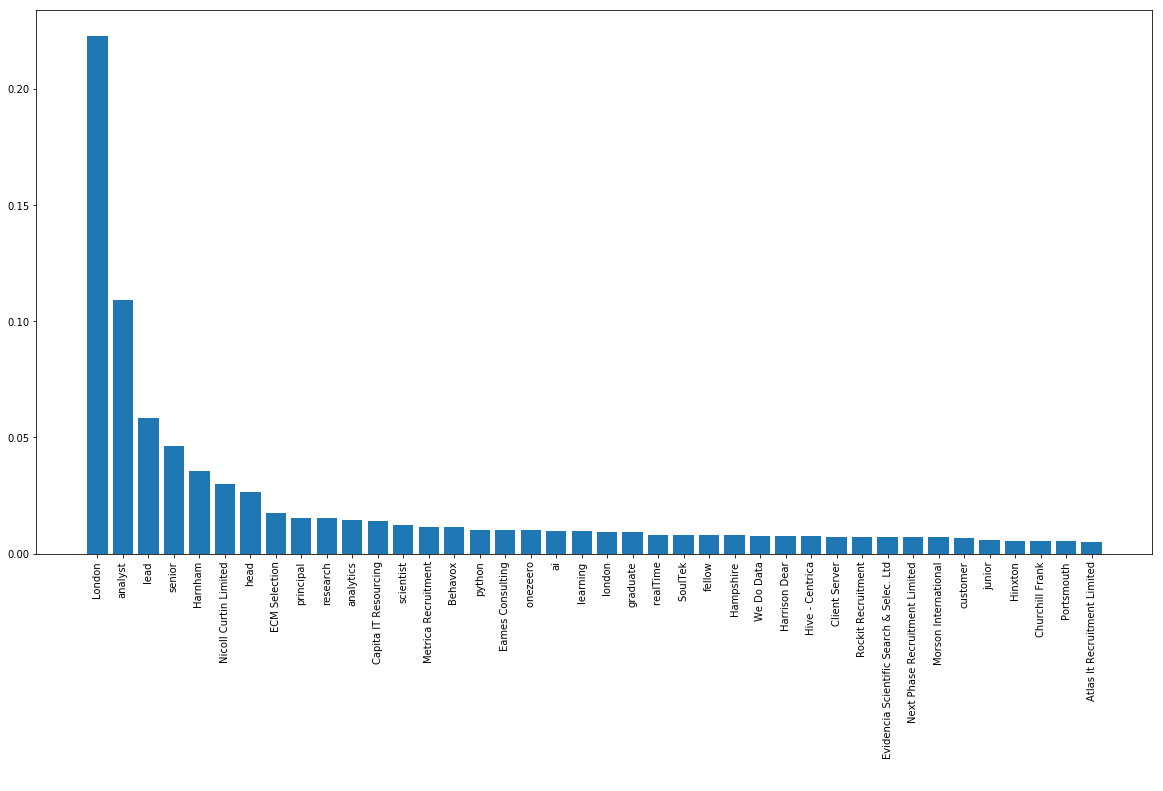

In [280]:
fig, ax = plt.subplots(figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.4)

ax.bar(x=gb_feat_imp_top.index,height=gb_feat_imp_top['gb_feat_imp'])

plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
#ax.set_xticklabels(gb_feat_imp.index)

plt.show()

This plot shows which features the Gradient Boost model found most useful in determining the splits for each level of the decision trees. However, it does not state whether the feature was a predictor of high or low salaries.

As expected, similar things are identified by this model as by the Logistic regression.

### Part III: model evaluation


#### Model evaluation:

It is better to incorrectly identify a job as a lower salary job than incorrectly identify a job as a high salary job, as this saves going through the application process for jobs, only to find the salary is below expectations. 

I adjusted one of the models to take this into account and reduce the likelihood of incorrectly predicting a job as high salary when in fact it was a low salary job.

#### Confusion matrix - original model

In [290]:
y_pred_rec = model_1.predict(X_train)

conmat = np.array(confusion_matrix(y_train, y_pred_rec, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,340,29
low_salary,51,321


In [317]:
y_pred_rec = model_1.predict(X_test)

conmat = np.array(confusion_matrix(y_test, y_pred_rec, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,71,22
low_salary,30,63


#### New model optimising for precision

In [391]:
gs_params = {
    'C':np.linspace(2,6,100),
    'penalty':['l2'],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

model = LogisticRegression()

gs_model = GridSearchCV(model,gs_params,n_jobs=-1,cv=7,verbose=1,scoring='precision')

gs_model.fit(X_train,y_train)

gs_best_model = gs_model.best_estimator_

scores = cross_val_score(gs_best_model,X_train,y_train,cv=7,scoring='precision')

print('Best parameters: ',gs_model.best_params_)
print('Cross val score: ',scores.mean())

Fitting 7 folds for each of 500 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 321 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 821 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 1521 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2421 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3493 out of 3500 | elapsed:  3.3min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed:  3.3min finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters:  {'C': 3.6565656565656566, 'penalty': 'l2', 'solver': 'newton-cg'}
Cross val score:  0.7688180298410734


#### New confusion matrix

In [392]:
y_pred_rec = gs_best_model.predict(X_train)

conmat = np.array(confusion_matrix(y_train, y_pred_rec, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,340,29
low_salary,48,324


This is already a step in the right direction - reducing the number of false positives for high salary on the training set.

In [393]:
y_pred_rec = gs_best_model.predict(X_test)

conmat = np.array(confusion_matrix(y_test, y_pred_rec, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,71,22
low_salary,30,63


However, it is no better for the test set. Further work needs to be done.

#### Increasing the threshold

By increasing the threshold (i.e. increasing the level of certainty required by the model for it to predict a high salary) this will reduce the number of false positives.

In [394]:
y_pred_proba_1 = pd.DataFrame(gs_best_model.predict_proba(X_train),columns=['%0','%1'],index=y_train.index)
y_pred_proba_1['y_pred_adj'] = [1 if i>0.8 else 0 for i in y_pred_proba_1['%1']]

conmat = np.array(confusion_matrix(y_train, y_pred_proba_1['y_pred_adj'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,191,178
low_salary,9,363


This is a significant improvement on the training set

In [395]:
probabilities = gs_best_model.predict_proba(X_test)
y_pred_proba_1 = pd.DataFrame(probabilities,columns=['%0','%1'],index=y_test.index)
y_pred_proba_1['y_pred_adj'] = [1 if i>0.8 else 0 for i in y_pred_proba_1['%1']]

conmat = np.array(confusion_matrix(y_test, y_pred_proba_1['y_pred_adj'], labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])
confusion

,predicted_high_salary,predicted_low_salary
high_salary,33,60
low_salary,10,83


That improvement continues for the test set

However, the tradeoff is a reduction in the total number of high salary jobs predicted, so the number of high salary jobs that are accurately predicted also decreases.

#### Accuracy, AUC, precision, recall

In [396]:
# Accuracy
print('Test set Accuracy: ',accuracy_score(y_test,y_pred_proba_1['y_pred_adj']))
print('Test set Precision: ',precision_score(y_test,y_pred_proba_1['y_pred_adj']))
print('Test set Recall: ',recall_score(y_test,y_pred_proba_1['y_pred_adj']))

fpr, tpr, threshold = roc_curve(y_test,y_pred_proba_1['%1'])
roc_auc = auc(fpr, tpr)

print('Test set AUC: ',roc_auc)

Test set Accuracy:  0.6236559139784946
Test set Precision:  0.7674418604651163
Test set Recall:  0.3548387096774194
Test set AUC:  0.7943114810960804


### ROC curve

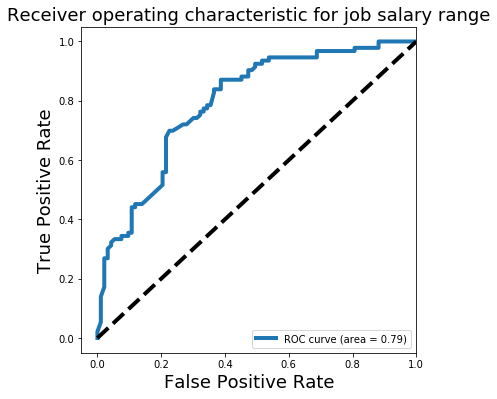

In [397]:
plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for job salary range', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Precision Recall curve

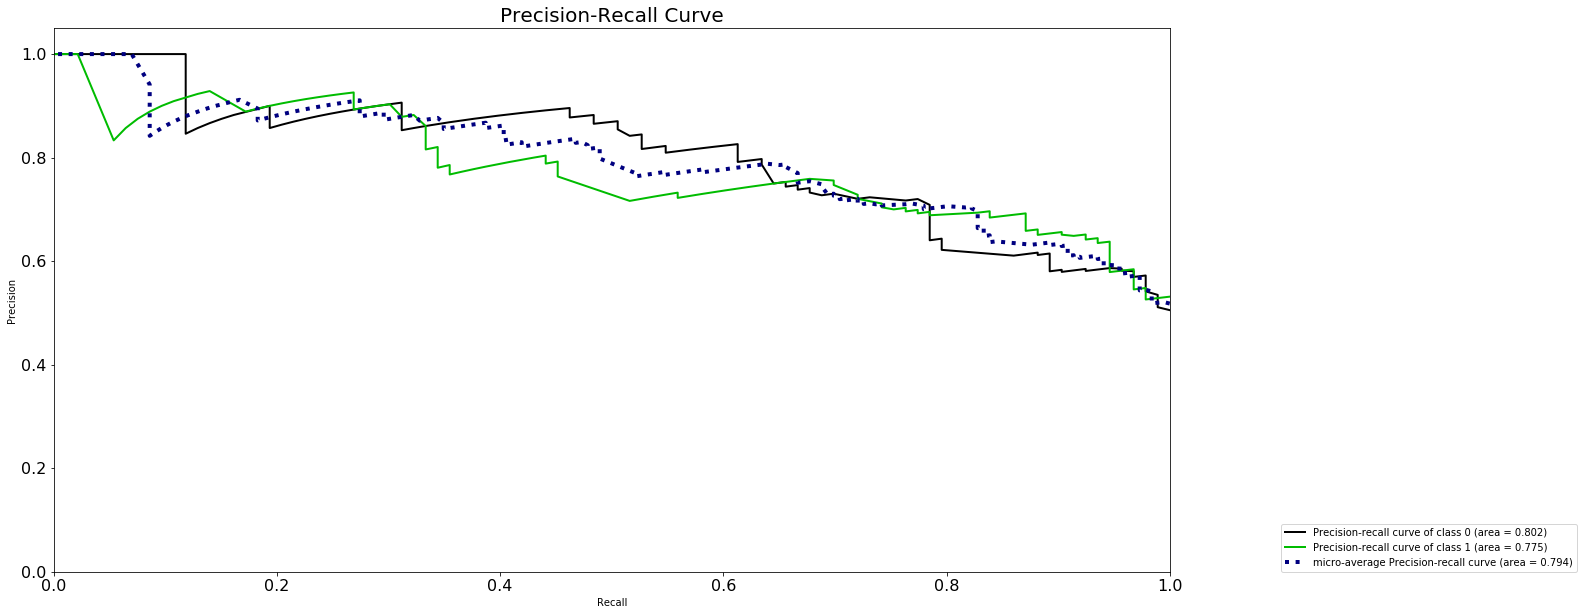

In [398]:
fig, ax = plt.subplots(figsize=(20,10))
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

As mentioned above, as you reduce the number of false positives in one category, the number of false positives for another category increases.

The minimal total number of false positives for either category is when the accuracy is highest.

However, in this scenario, as we don't want to over promise for high salaries we are reducing the overall accuracy score (and the precision) in the interests of reducing the number of false positives for high salaries.

In this scenario we would want higher precision (rather than higher recall or accuracy). Precision is maximised when there are less false positives (which is what we are trying to achieve).

In addition, we can amend the threshold to further reduce the number of false positives (but therefore increasing the number of false negatives).

### Gradient boost 

{'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 1, 'n_estimators': 810}

In [384]:
model = GradientBoostingClassifier(criterion='friedman_mse',loss='exponential',max_depth=1,
                                   n_estimators=810,random_state=1)

model.fit(X_train,y_train)

probabilities = model.predict_proba(X_test)
y_pred_proba = pd.DataFrame(probabilities,columns=['%0','%1'],index=y_test.index)
predictions = model.predict(X_test)

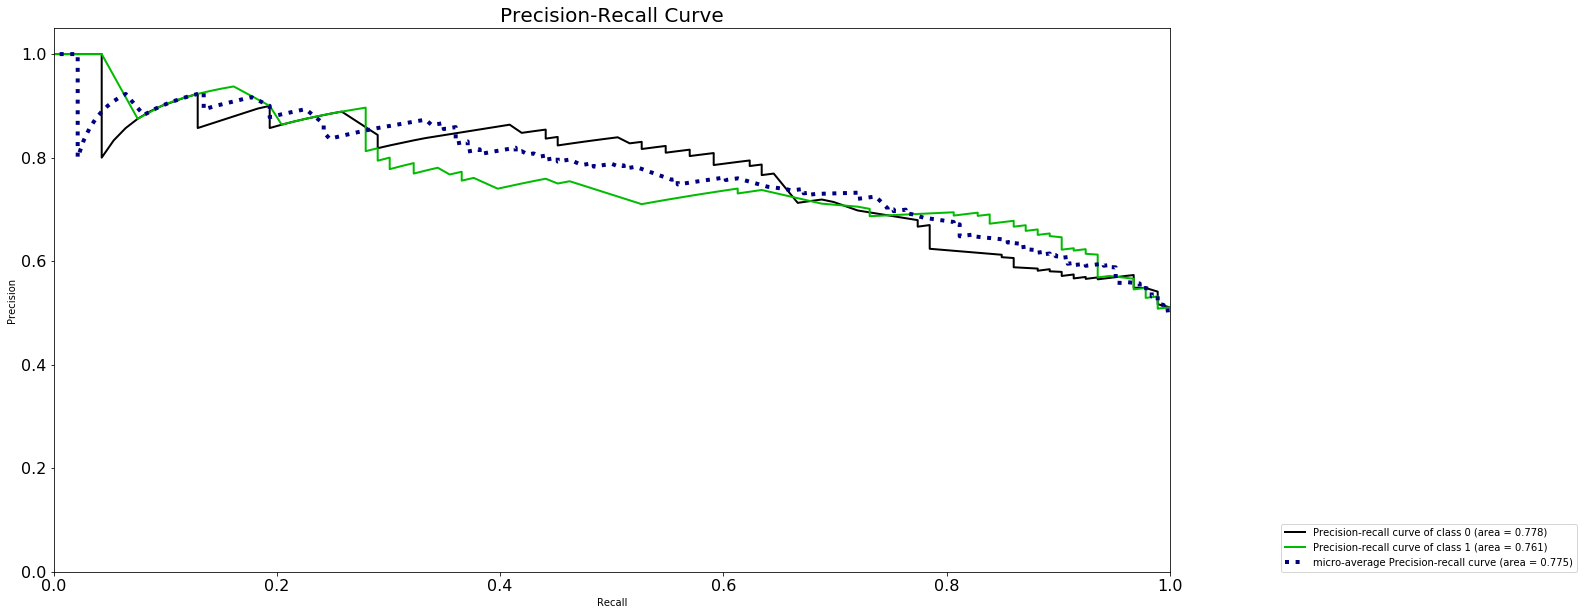

In [385]:
fig, ax = plt.subplots(figsize=(20,10))
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

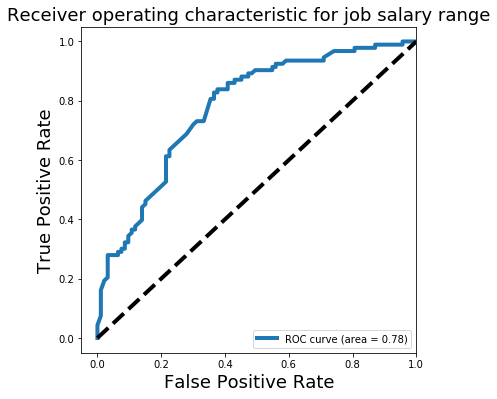

In [386]:
fpr, tpr, threshold = roc_curve(y_test,y_pred_proba['%1'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for job salary range', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Ada boost

In [388]:
base_estimator = DecisionTreeClassifier(max_depth=1)

model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=23, random_state=1)

model.fit(X_train,y_train)

probabilities = model.predict_proba(X_test)
y_pred_proba = pd.DataFrame(probabilities,columns=['%0','%1'],index=y_test.index)
predictions = model.predict(X_test)

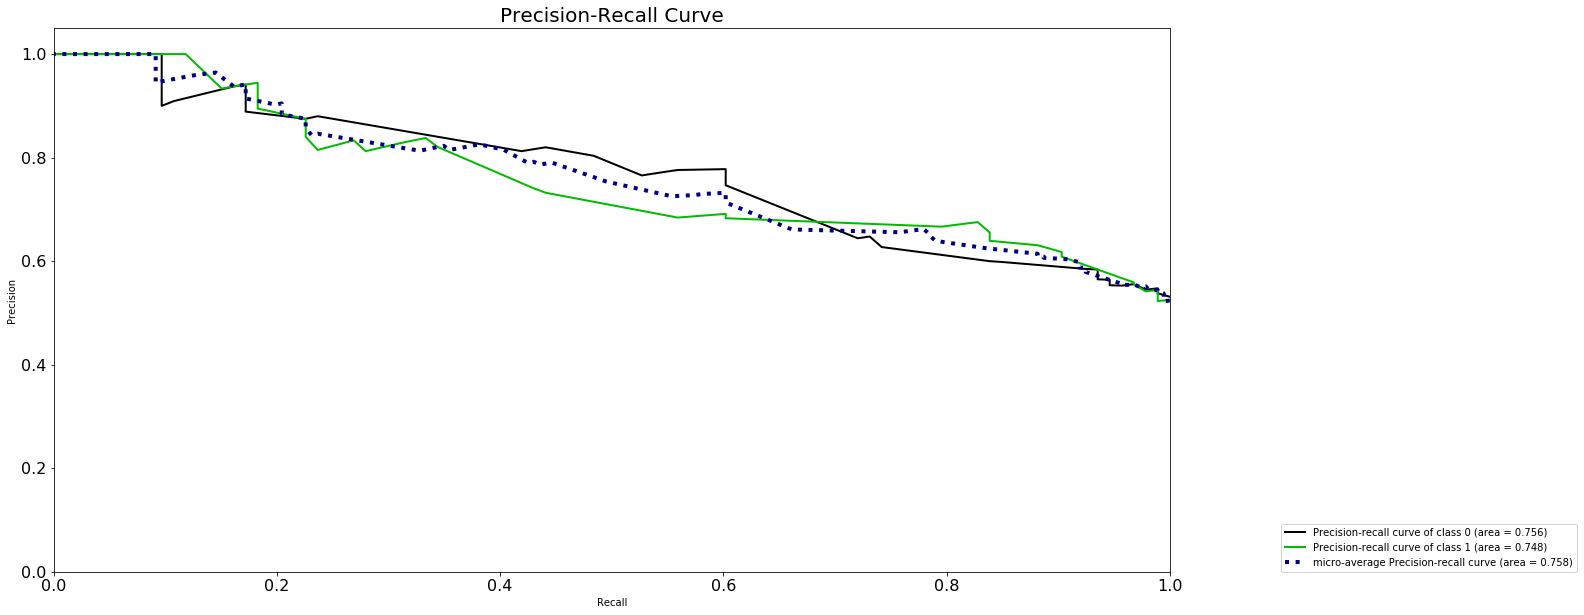

In [389]:
fig, ax = plt.subplots(figsize=(20,10))
skplt.metrics.plot_precision_recall(y_test, probabilities, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

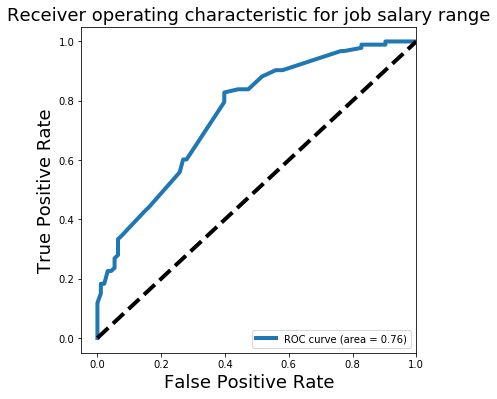

In [390]:
fpr, tpr, threshold = roc_curve(y_test,y_pred_proba['%1'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6,6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for job salary range', fontsize=18)
plt.legend(loc="lower right")
plt.show()

None of the ROC curves show a particularly strong model. However, for the Logistic Regression model, there definitely appear to be some steps in the curve that would significantly reduce the number of false positives whilst not affecting the number of true positives to the same degree. The same is also true in the other direction, so selecting the best threshold value will be difficult.